In [36]:
import numpy as np
import collections 
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
from scipy import sparse
from typing import List
import scipy.sparse as sp

for dirname, _, filenames in os.walk('/home/ebcffhh/Documents/personal/Masters/Thesis'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/ebcffhh/Documents/personal/Masters/Thesis/coverage.png
/home/ebcffhh/Documents/personal/Masters/Thesis/rating_distribution.png
/home/ebcffhh/Documents/personal/Masters/Thesis/nn_models.ipynb
/home/ebcffhh/Documents/personal/Masters/Thesis/diversity.png
/home/ebcffhh/Documents/personal/Masters/Thesis/svd.ipynb
/home/ebcffhh/Documents/personal/Masters/Thesis/novelty2.png
/home/ebcffhh/Documents/personal/Masters/Thesis/coverage_dnn.png
/home/ebcffhh/Documents/personal/Masters/Thesis/mae1.png
/home/ebcffhh/Documents/personal/Masters/Thesis/recommendation_thesis.ipynb
/home/ebcffhh/Documents/personal/Masters/Thesis/svd_diversity.png
/home/ebcffhh/Documents/personal/Masters/Thesis/accuracy.png
/home/ebcffhh/Documents/personal/Masters/Thesis/svd_diversity_new.png
/home/ebcffhh/Documents/personal/Masters/Thesis/mae.png
/home/ebcffhh/Documents/personal/Masters/Thesis/f1.png
/home/ebcffhh/Documents/personal/Masters/Thesis/dnn_diversity.png
/home/ebcffhh/Documents/personal/Masters/Thesis/th

In [37]:
data=pd.read_csv("/home/ebcffhh/Documents/personal/Masters/Thesis/ratings_Beauty.csv", names = ["userId", "ProductId", "Ratings", "Timestamp"])


In [38]:
counts=data.userId.value_counts()
dataset_final=data[data.userId.isin(counts[counts>=25].index)]
print('Number of users who have rated 25 or more items =', len(dataset_final))
print('Number of unique users in the final data = ', dataset_final['userId'].nunique())
print('Number of unique products in the final data = ', dataset_final['ProductId'].nunique())

Number of users who have rated 25 or more items = 73188
Number of unique users in the final data =  1691
Number of unique products in the final data =  33840


In [39]:
rated_products = data.groupby(by='userId',as_index=False)['Ratings'].count()
print(rated_products)
rated_products = rated_products[rated_products['Ratings'] < 20]
new_dataset = data.loc[~((data.userId.isin(rated_products['userId']))),:]
no_of_rated_products_per_user = new_dataset.groupby(by='userId')['Ratings'].count().sort_values(ascending=False)
print(no_of_rated_products_per_user)
print(new_dataset.ProductId.nunique())
print(new_dataset.userId.nunique())

                        userId  Ratings
0        A00008821J0F472NDY6A2        1
1        A000186437REL8X2RW8UW        1
2         A0002574WYJMBWKNCPY8        1
3        A00029263J863WSR0TDRS        1
4         A00031961JI1CBNV98TW        1
...                        ...      ...
1210266          AZZZLZXCEE4WK        2
1210267          AZZZMSZI9LKE6        4
1210268          AZZZO4QCZROW8        1
1210269          AZZZRS1YZ8HVP        1
1210270          AZZZU2TD7Q3ET        1

[1210271 rows x 2 columns]
userId
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
                 ... 
A2ZLKIA9YLK1A9     20
AA1ZYCEKJGG3A      20
A2ZFJY6P72SC1U     20
A1Y7TIDOJ90CCW     20
AHXWPY977L7VF      20
Name: Ratings, Length: 2826, dtype: int64
42042
2826


In [40]:
n_users = new_dataset.userId.unique().shape[0]
n_products = new_dataset.ProductId.unique().shape[0]
product_list = new_dataset.ProductId.unique().tolist()
print(n_users)

2826


In [41]:
from collections import defaultdict
def GetTopN(predictions, n=10, minimumRating=4.0):
      topN = defaultdict(list)


      for userID, productId, actualRating, estimatedRating, _ in predictions:
          if (estimatedRating >= minimumRating):
              topN[userID].append((productId, estimatedRating))
      for userID, ratings in topN.items():
          ratings.sort(key=lambda x: x[1], reverse=True)
          topN[userID] = ratings[:n]

      return topN

In [42]:
def get_customer_satisfaction(pred_u,k):
  edt = {}
  rating_list = defaultdict(list)
  pred = pred_u.copy().groupby(['userId'])
  for userId in pred.groups.keys():
    sorted_pred_group = pred.get_group(userId).sort_values(['prediction'], ascending = False)
    top_k = sorted_pred_group[:k]
    top_k_g = top_k.groupby(by='userId')

    for userId in top_k_g.groups.keys():
      top_k_user_list = top_k_g.get_group(userId)
      for _, groups in top_k_user_list.iterrows():
        diff_ratings = groups['prediction'] - groups['actual']
        rating_list.setdefault(groups['userId'], []).append(diff_ratings)
      edt[userId] = (np.sum(rating_list.get(userId)))
  return edt

In [43]:
def prediction_coverage(predicted: List[list], catalog: list) -> float:
  predicted_flattened = [p for sublist in predicted for p in sublist]
  unique_predictions = len(set(predicted_flattened))
  prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
  return prediction_coverage

In [44]:
def recommender_precision(predicted: List[list], actual: List[list]) -> int:
  def calc_precision(predicted, actual):
      prec = [value for value in predicted if value in actual]
      prec = np.round(float(len(prec)) / float(len(predicted)), 4)
      return prec

  precision_list = list(map(calc_precision, predicted, actual))
  precision = np.mean(precision_list)
  return precision, precision_list


def recommender_recall(predicted: List[list], actual: List[list]) -> int:
  def calc_recall(predicted, actual):
      reca = [value for value in predicted if value in actual]
      reca = np.round(float(len(reca)) / float(len(actual)), 4)
      return reca

  recall_list = list(map(calc_recall, predicted, actual))
  recall = np.mean(recall_list)
  return recall, recall_list

In [45]:
def personalization(predicted: List[list]) -> float:
    """
    Personalization measures recommendation similarity across users.
    A high score indicates good personalization (user's lists of recommendations are different).
    A low score indicates poor personalization (user's lists of recommendations are very similar).
    A model is "personalizing" well if the set of recommendations for each user is different.
    Parameters:
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        The personalization score for all recommendations.
    """

    def make_rec_matrix(predicted: List[list]) -> sp.csr_matrix:
        df = pd.DataFrame(data=predicted).reset_index().melt(
            id_vars='index', value_name='item',
        )
        df = df[['index', 'item']].pivot(index='index', columns='item', values='item')
        df = pd.notna(df)*1
        rec_matrix = sp.csr_matrix(df.values)
        return rec_matrix

    #create matrix for recommendations
    predicted = np.array(predicted)
    rec_matrix_sparse = make_rec_matrix(predicted)

    #calculate similarity for every user's recommendation list
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)
  

    avg_sim = similarity.mean(axis=1)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return avg_sim, (1 - ils_single_user)
    #return similarity

In [46]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

reader = Reader()
rating_data = Dataset.load_from_df(new_dataset[['userId', 'ProductId', 'Ratings']], reader)
trainset, testset = train_test_split(rating_data, test_size=0.2,random_state=100)

In [47]:
from surprise import SVD
from surprise import KNNWithMeans

from surprise import accuracy

k = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

mae_svd = list()
for i in k:
  algo = SVD(n_factors=i, n_epochs=200)
  algo.fit(trainset)
  test_pred = algo.test(testset)
  mae_svd.append(accuracy.mae(test_pred))
  print("Mean Absolute Error for value k {} is ".format(i), accuracy.mae(test_pred))

MAE:  0.8409
MAE:  0.8409
Mean Absolute Error for value k 5 is  0.8409360751523484
MAE:  0.8404
MAE:  0.8404
Mean Absolute Error for value k 10 is  0.8404434386539776
MAE:  0.8352
MAE:  0.8352
Mean Absolute Error for value k 15 is  0.8351787090096253
MAE:  0.8360
MAE:  0.8360
Mean Absolute Error for value k 20 is  0.8360092061763327
MAE:  0.8265
MAE:  0.8265
Mean Absolute Error for value k 30 is  0.8265017817807114
MAE:  0.8207
MAE:  0.8207
Mean Absolute Error for value k 40 is  0.8207226588199115
MAE:  0.8181
MAE:  0.8181
Mean Absolute Error for value k 50 is  0.8180569153953086
MAE:  0.8165
MAE:  0.8165
Mean Absolute Error for value k 60 is  0.8164519420864585
MAE:  0.8183
MAE:  0.8183
Mean Absolute Error for value k 70 is  0.8183354864174198
MAE:  0.8146
MAE:  0.8146
Mean Absolute Error for value k 80 is  0.8146252420359832
MAE:  0.8144
MAE:  0.8144
Mean Absolute Error for value k 90 is  0.8143705794905562
MAE:  0.8133
MAE:  0.8133
Mean Absolute Error for value k 100 is  0.813318812

In [48]:
from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


k = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
reader = Reader()
rating_data = Dataset.load_from_df(new_dataset[['userId', 'ProductId', 'Ratings']], reader)
trainset, testset = train_test_split(rating_data, test_size=0.2,random_state=100)


mae_knn = list()
for i in k:
  algo = KNNWithMeans(k=i, sim_options={'name':'pearson','user_based': True})
  algo.fit(trainset)
  test_pred = algo.test(testset)
  mae_knn.append(accuracy.mae(test_pred))
  print("Mean Absolute Error for value k {} is ".format(i), accuracy.mae(test_pred))

Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8553
MAE:  0.8553
Mean Absolute Error for value k 5 is  0.8552804076599626
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8532
MAE:  0.8532
Mean Absolute Error for value k 10 is  0.8532044799597551
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8527
MAE:  0.8527
Mean Absolute Error for value k 15 is  0.8526680674367112
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8525
MAE:  0.8525
Mean Absolute Error for value k 20 is  0.8525444677652285
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8525
MAE:  0.8525
Mean Absolute Error for value k 30 is  0.8525168677863482
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8525
MAE:  0.8525
Mean Absolute Error for value k 40 is  0.8525103655838698
Computing the pearson similarity ma

In [49]:
from scipy.stats import entropy
def get_f1_score(predictions, k):
    threshold = 4
    # First map the predictions to each user.
    user_est_rating = defaultdict(list)
    
    for index, row in predictions.iterrows():
        user_est_rating[row['userId']].append((row['prediction'], row['actual']))
    # Then sort the predictions for each user and retrieve the k highest ones.
    f1_score = dict()
    for uid, user_ratings in user_est_rating.items():
        user_ratings.sort(key=lambda x:x[0], reverse=True)
        # Number of relevant items
        n_rel = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)
        if math.isnan(n_rel):
          print("nan value for rel") 
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        if math.isnan(n_rec_k):
          print("nan value for rel") 
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        if math.isnan(n_rel_and_rec_k):
          print("nan value for rel and rec") 
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        f1_score[uid] = 2 * ((precision * recall)/(precision+recall)) if (precision + recall) != 0 else 0
    return f1_score

def get_cus(predictions, k):
    threshold = 4
    # First map the predictions to each user.
    user_est_rating = defaultdict(list)
    for index, row in predictions.iterrows():
      user_est_rating[row['userId']].append((row['prediction'], row['actual']))

    # Then sort the predictions for each user and retrieve the k highest ones.
    cus = defaultdict(list)
    for uid, user_ratings in user_est_rating.items():
        user_ratings.sort(key=lambda x:x[0], reverse=True)
        for est, r_ui in user_ratings[:k]:
          diff = r_ui - est
          cus[uid].append(diff)
    customerSatisfaction = {}
    for key in cus:
      customerSatisfaction[key] = np.sum(cus.get(key))/k
    return customerSatisfaction

def get_f1_score_nn(predictions, k):
    threshold = 4
    # First map the predictions to each user.
    user_est_rating = defaultdict(list)
    #for uid, iid, r_ui, est in predictions:
    #    user_est_rating[uid].append((est, r_ui))
    for index, row in predictions.iterrows():
        user_est_rating[row['userId']].append((row['prediction'], row['actual']))
    # Then sort the predictions for each user and retrieve the k highest ones.
    f1_score = dict()
    for uid, user_ratings in user_est_rating.items():
        user_ratings.sort(key=lambda x:x[0], reverse=True)
        # Number of relevant items
        n_rel = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)
        if math.isnan(n_rel):
          print("nan value for rel") 
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        if math.isnan(n_rec_k):
          print("nan value for rel") 
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        if math.isnan(n_rel_and_rec_k):
          print("nan value for rel and rec") 
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        f1_score[uid] = 2 * ((precision * recall)/(precision+recall)) if (precision + recall) != 0 else 0
    return f1_score

def cal_f1(test_pred, k):
  f1_scores = get_f1_score(test_pred, k)
  average_f1_score = sum(score for score in f1_scores.values())/ len(f1_scores)
  return f1_scores , average_f1_score 

def get_accuracy(predictions,k):
  user_est_rating = defaultdict(list)
  for index, row in predictions.iterrows():
      user_est_rating[row['userId']].append((row['prediction'], row['actual']))
  accuracy_scores = dict()
  for uid, user_ratings in user_est_rating.items():
    scores = list()
    user_ratings.sort(key=lambda x:x[0], reverse=True)
    for (est, actual) in user_ratings[:k]:
      diff = abs(actual - est)
      scores.append(diff)
    accuracy_scores[uid] = sum(score for score in scores)/len(scores)
  return accuracy_scores

def cal_accuracy(test_pred, k):
  accuracy = get_accuracy(test_pred, k)
  average_accuracy = sum(score for score in accuracy.values())/len(accuracy)
  return accuracy , average_accuracy

def get_shannon_entropy(predictions, product_list, no_of_recommendations):
  recommendation_items = [item for sublist in predictions for item in sublist]
  products = set(recommendation_items)
  count_recommendation_items = collections.Counter(recommendation_items)
  print(count_recommendation_items)
  pi = list()
  for product in products:
    #if product in count_recommendation_items.keys():
    pi.append(count_recommendation_items.get(product)/len(set(product_list)))
  #e = -np.sum(pi*np.log(pi)/np.log(no_of_recommendations))
  e = -np.sum(pi*np.log(pi))
  return e
  #print("Average diversity using shannon entropy for {} no of recommendations is {} \n".format(no_of_recommendations, -np.sum(pi*np.log(pi)/np.log(no_of_recommendations))))
def get_shannon_entropy_new(predictions, product_list, no_of_recommendations):
  recommendation_items = [item for sublist in predictions for item in sublist]
  products = set(recommendation_items)
  count_recommendation_items = collections.Counter(recommendation_items)
  n_rec = sum(count_recommendation_items.values())
  c = np.fromiter(count_recommendation_items.values(), dtype=int)
  pi = c/n_rec
  shannon_entropy = -np.sum(pi * np.log2(pi))
  return shannon_entropy

def get_s_entropy(predictions, count_recommended_products, total_products):
  entropy_list = []
  for recommended_product_list in predictions:
    probability_list_each_user = []
    for recommended_product in recommended_product_list:
      probability_list_each_user.append(count_recommended_products.get(recommended_product)/len(total_products))
    entropy_list.append(entropy(probability_list_each_user))
  return np.mean(entropy_list)
    

In [50]:
import re
def sorted_nicely( l ):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [52]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import Counter
import recmetrics
import csv

ratings_dataset = Dataset.load_from_df(new_dataset[['userId', 'ProductId', 'Ratings']],reader)

trainset, testset = train_test_split(ratings_dataset, test_size=.2)

total_products = set([x[1] for x in testset])

product_list = set()

for inner_pid in trainset.ir.keys():
  product_list.add(trainset.to_raw_iid(inner_pid))

algo = SVD(n_factors= 80, n_epochs=200)
algo.fit(trainset)
predictions = algo.test(testset)
test = pd.DataFrame(predictions)
test = test.rename(columns={'uid':'userId', 'iid': 'productId', 
                            'r_ui':'actual', 'est':'prediction'})
pred_user = test.copy().groupby('userId', as_index=False)['productId'].agg({'ratings': (lambda x: list(set(x)))})
pred_user = pred_user.set_index("userId")                            
cf_model = test.pivot_table(index='userId', 
                            columns='productId', values='prediction').fillna(0)

def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

def get_recs(model, k):
    recs = []
    for user in model.index:
        cf_predictions = get_users_predictions(user, k, model)
        recs.append(cf_predictions)
    return recs

productId_counts = dict(new_dataset.ProductId.value_counts())
userId_counts = test['userId'].value_counts()

diversity_svd = []
novelty_svd = []
coverage_svd = []
f1_score_svd = []
accuracy_svd = []
entropy_svd = []

# Top-n recommendations for each user
no_of_recommendations = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#no_of_recommendations = [5]
for k in no_of_recommendations:
  recs = get_recs(cf_model, k)
  flat_list_recommendations = [item for sublist in recs for item in sublist]
  product_counts = Counter(flat_list_recommendations)

  pred_user[f'Top-{k} Recommendation'] = recs

  # To calculate entropy
  entropy_score = get_s_entropy(recs, product_counts, set(flat_list_recommendations))
  print("The entropy score for {} recommendation is {} \n".format(k, entropy_score))
  entropy_svd.append(entropy_score)


  # To calculate the f1_score
  f1_scores_list_svd, average_f1_score_svd = cal_f1(test.copy() ,k)
  print("The f1 score for {} recommendation is {} \n".format(k, average_f1_score_svd))
  f1_score_svd.append(average_f1_score_svd)

  # To calculate accuracy
  accuracy_scores_svd, average_accuracy_svd = cal_accuracy(test.copy() ,k)
  print("The accuracy score for {} recommendation is {} \n".format(k, average_accuracy_svd))
  accuracy_svd.append(average_accuracy_svd)

  # To calculate the diversity
  diversity_scores_svd, average_diversity_svd = personalization(list(recs))
  #diversity = get_shannon_entropy_new(recs, list(product_list), k)
  print("The diversity score for {} recommendation is {} \n".format(k, average_diversity_svd))
  diversity_svd.append(average_diversity_svd)

  # To calculate the novelty
  cf_novelty_svd, novelty_list_svd = recmetrics.novelty(recs, productId_counts, len(userId_counts), k)
  print("The novelty score for {} recommendation is {} \n".format(k, cf_novelty_svd))
  novelty_svd.append(cf_novelty_svd)

  # To calculate the coverage
  cf_coverage = recmetrics.catalog_coverage(list(recs), product_list, 100)
  print("The coverage score for {} recommendation is {} \n".format(k, cf_coverage))
  coverage_svd.append(cf_coverage)

  # To calculate the customer satisfaction
  edt_svd = get_customer_satisfaction(test, k)
  print("The cusotmer satisfaction for {} recommendation is {}".format(k,  np.mean(list(edt_svd.values()))))

  filename = "/home/ebcffhh/thesis/sorted_svd/metrics_svd_%s_recommendations.csv" % k
  with open(filename, 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(['userId', 'accuracy', 'f1_score', 'diversity', 'novelty', 'customer_satisfaction'])
    for i, nov, (uid, acc_score), (_, f1_score) in zip(diversity_scores_svd, novelty_list_svd, accuracy_scores_svd.items(), f1_scores_list_svd.items()):
       if uid in sorted_nicely(edt_svd.keys()):
         writer.writerow([uid, acc_score, f1_score, (1 - i[0]), nov, edt_svd.get(uid)])

print(accuracy_svd)

The entropy score for 5 recommendation is 1.1429446772477008 

The f1 score for 5 recommendation is 0.6061566695397193 

The accuracy score for 5 recommendation is 0.7982939566514845 

The diversity score for 5 recommendation is 0.9866947214585253 

The novelty score for 5 recommendation is 9.164875998018886 

The coverage score for 5 recommendation is 1.17 

The cusotmer satisfaction for 5 recommendation is 0.2702548136346354
The entropy score for 10 recommendation is 1.5012922256528696 

The f1 score for 10 recommendation is 0.6609576487823602 

The accuracy score for 10 recommendation is 0.821651812039717 

The diversity score for 10 recommendation is 0.8645805975609941 

The novelty score for 10 recommendation is 9.349609002456035 

The coverage score for 10 recommendation is 1.56 

The cusotmer satisfaction for 10 recommendation is 0.14062165873196836
The entropy score for 15 recommendation is 2.066221673453127 

The f1 score for 15 recommendation is 0.6696307400269758 

The accur

In [53]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
import recmetrics

#ratings_dataset = Dataset.load_from_df(new_dataset[['userId', 'ProductId', 'Ratings']],reader)

#trainset, testset = train_test_split(ratings_dataset, test_size=.2)

train_product_list_count = len(trainset.ir.keys())
productId_counts = dict(new_dataset.ProductId.value_counts())
userId_counts = new_dataset['userId'].value_counts()
product_list = set()

for inner_pid in trainset.ir.keys():
  product_list.add(trainset.to_raw_iid(inner_pid))

algo = KNNWithMeans(k=100, sim_options={'name':'pearson','user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)
test = pd.DataFrame(predictions)
test = test.rename(columns={'uid':'userId', 'iid': 'productId', 
                            'r_ui':'actual', 'est':'prediction'})
pred_user = test.copy().groupby('userId', as_index=False)['productId'].agg({'ratings': (lambda x: list(set(x)))})
pred_user = pred_user.set_index("userId")    
cf_model = test.pivot_table(index='userId', 
                            columns='productId', values='prediction').fillna(0)

def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

def get_recs(model, k):
    recs = []
    for user in model.index:
        cf_predictions = get_users_predictions(user, k, model)
        recs.append(cf_predictions)
    return recs    
diversity_knn = []
novelty_knn = []
coverage_knn = []
f1_score_knn = []
accuracy_knn = []
entropy_knn = []

# Top-n recommendations for each user
no_of_recommendations = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for k in no_of_recommendations:
  
  recs = get_recs(cf_model, k)

  pred_user[f'Top-{k} Recommendation'] = recs
  flat_list_recommendations = [item for sublist in recs for item in sublist]
  product_counts = Counter(flat_list_recommendations)
  
  # To calculate entropy
  entropy_score = get_s_entropy(recs, product_counts, set(flat_list_recommendations))
  print("The entropy score for {} recommendation is {} \n".format(k, entropy_score))
  entropy_knn.append(entropy_score)


  # To calculate the f1_score
  f1_scores_knn, average_f1_score = cal_f1(test ,k)
  print("The f1 score for {} recommendation is {} \n".format(k, average_f1_score))
  f1_score_knn.append(average_f1_score)

  # To calculate accuracy
  accuracy_scores_knn, average_accuracy_knn = cal_accuracy(test.copy() ,k)
  print("The accuracy score for {} recommendation is {} \n".format(k, average_accuracy_knn))
  accuracy_knn.append(average_accuracy_knn)

  # To calculate the diversity
  diversity_scores_knn, average_diversity_knn = personalization(list(recs))
  #diversity = get_shannon_entropy(recs, list(product_list), k)
  print("The diversity score for {} recommendation is {} \n".format(k, average_diversity_knn))
  diversity_knn.append(average_diversity_knn)

  # To calculate the novelty
  cf_novelty_knn, novelty_list_knn = recmetrics.novelty(list(recs), productId_counts, len(userId_counts), k)
  print("The novelty score for {} recommendation is {} \n".format(k, cf_novelty_knn))
  novelty_knn.append(cf_novelty_knn)

  # To calculate the coverage
  cf_coverage_knn = recmetrics.catalog_coverage(list(recs), product_list, 100)
  print("The coverage score for {} recommendation is {} \n".format(k, cf_coverage_knn))
  coverage_knn.append(cf_coverage_knn)
  
  # To calculate the customer satisfaction
  edt_knn = get_customer_satisfaction(test, k)
  print("The cusotmer satisfaction for {} recommendation is {}".format(k,  np.mean(list(edt_knn.values()))))

  filename = "/home/ebcffhh/thesis/sorted_knn/metrics_knn_%s_recommendations.csv" % k
  with open(filename, 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(['userId', 'accuracy', 'f1_score', 'diversity', 'novelty', 'customer_satisfaction'])
    for i, nov, (uid, acc_score), (_, f1_score) in zip(diversity_scores_knn, novelty_list_knn, accuracy_scores_knn.items(), f1_scores_knn.items()):
       if uid in sorted_nicely(edt_knn.keys()):
         writer.writerow([uid, acc_score, f1_score, (1 - i[0]), nov, edt_knn.get(uid)])
  

Computing the pearson similarity matrix...
Done computing similarity matrix.
The entropy score for 5 recommendation is 1.1495104513027294 

The f1 score for 5 recommendation is 0.6522685511744399 

The accuracy score for 5 recommendation is 0.8377630510531505 

The diversity score for 5 recommendation is 0.9867552943045838 

The novelty score for 5 recommendation is 9.156185476784444 

The coverage score for 5 recommendation is 1.19 

The cusotmer satisfaction for 5 recommendation is 0.29695194207474956
The entropy score for 10 recommendation is 1.5067575029150089 

The f1 score for 10 recommendation is 0.7179250318538697 

The accuracy score for 10 recommendation is 0.8568000849836381 

The diversity score for 10 recommendation is 0.8654769188106266 

The novelty score for 10 recommendation is 9.345812660193934 

The coverage score for 10 recommendation is 1.56 

The cusotmer satisfaction for 10 recommendation is 0.09342907340782818
The entropy score for 15 recommendation is 2.0654289

In [54]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(new_dataset, test_size = 0.2)

user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

train_user_ids = np.array([one_hot(d,10) for d in train_data['userId']])
train_product_ids = np.array([one_hot(d,10) for d in train_data['ProductId']])
test_product_ids = np.array([one_hot(d,10) for d in test_data['ProductId']])
test_user_ids = np.array([one_hot(d,10) for d in test_data['userId']])

num_users= train_user_ids.max()+1
num_products = train_product_ids.max() + 1
print(num_users)

10


In [55]:
from keras.layers.normalization.batch_normalization import BatchNormalization

import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, dot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, dot, Multiply, Dropout
from keras.preprocessing.text import one_hot,Tokenizer
import keras.layers
from keras.optimizers import adam_v2
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf

def get_ncf_model(no_of_factors):

  product_input = Input(shape = [1], name = "Product-Input")
  user_input = Input(shape = [1], name = "User-Input")



  # Product embedding for GMF
  gmf_product_embedding = Embedding(n_products, no_of_factors, name= "GMF-Product-Embedding", embeddings_initializer="he_normal")(product_input)
  

  # User embedding for GMF
  gmf_user_embedding = Embedding(n_users, no_of_factors, name = "GMF-User-Embedding", embeddings_initializer="he_normal")(user_input)
  
  # GMF layers
  gmf_product_vec = Flatten(name = "GMF-Flatten-Products")(gmf_product_embedding)
  gmf_user_vec = Flatten(name = "GMF-Flatten-Users")(gmf_user_embedding)
  gmf_output = Multiply()([gmf_user_vec, gmf_product_vec])

  
  # Product embedding for MLP
  mlp_product_embedding = Embedding(n_products, no_of_factors, name= "MLP-Product-Embedding", embeddings_initializer="he_normal")(product_input)
  

  # User embedding for MLP
  mlp_user_embedding = Embedding(n_users, no_of_factors, name = "MLP-User-Embedding", embeddings_initializer="he_normal")(user_input)

  # MLP layers

  mlp_product_vec = Flatten(name = "MLP-Flatten-Products")(mlp_product_embedding)
  mlp_user_vec = Flatten(name = "MLP-Flatten-Users")(mlp_user_embedding)

  #Concatenate features
  conc = Concatenate()([mlp_product_vec, mlp_user_vec])

  fc1 = Dropout(0.2)(conc)
  fc2 = Dense(64, activation='relu')(fc1)
  fc3 = BatchNormalization()(fc2)

  fc4 = Dropout(0.2)(fc3)
  fc5 = Dense(32, activation='relu')(fc4)
  fc6 = BatchNormalization()(fc5)

  fc7 = Dropout(0.2)(fc6)

  fc8 = Dense(16, activation='relu')(fc7)
  fc9 = BatchNormalization()(fc8)

  fc10 = Dropout(0.2)(fc9)
  fc11 = Dense(8, activation='relu')(fc10)
  final_conc = Concatenate()([gmf_output, fc11])
  output = Dense(1, activation='relu')(final_conc)

 
  #Create model and compile it
  opt = keras.optimizers.adam_v2.Adam(learning_rate=0.001)
  model = Model([user_input, product_input], output)
  model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'] )
  #model = Model([user_input, product_input], output)
  #model.compile('adam', 'mean_absolute_error')
  return model


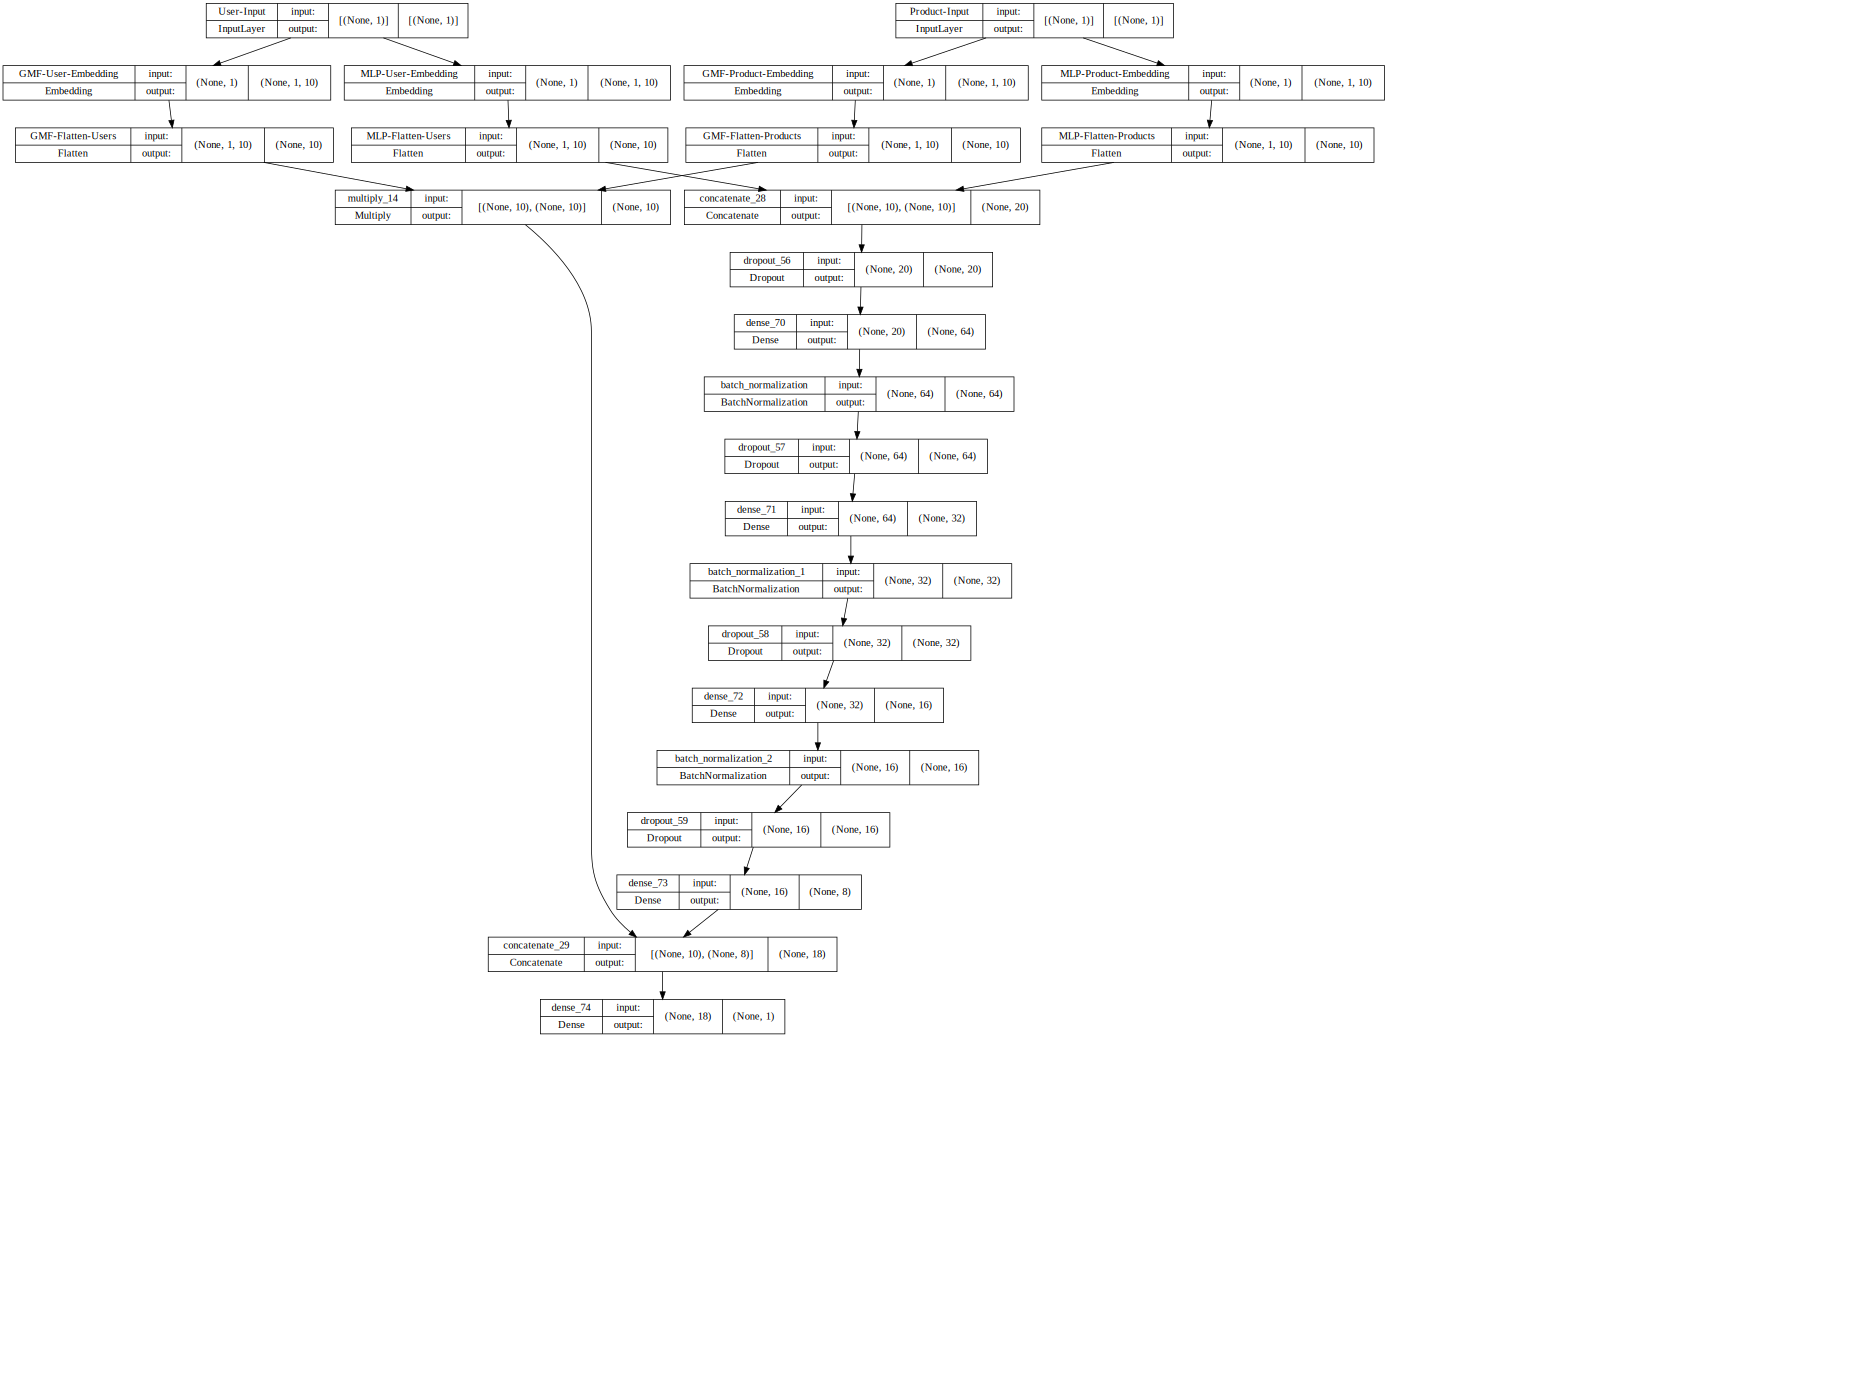

In [56]:
from IPython.display import SVG

model = get_ncf_model(10)
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [57]:
from sklearn.metrics import mean_absolute_error
no_of_factors = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

mae_ncf = list()
for k in no_of_factors:
  model = get_ncf_model(k)
  model.fit([train_user_ids, train_product_ids], train_data['Ratings'], epochs=3)
  prediction = model.predict([test_user_ids, test_product_ids])
  mae_ncf.append(mean_absolute_error(test_data['Ratings'], prediction))
  print("Mean Absolute Error for value k {} is ".format(k), mean_absolute_error(test_data['Ratings'], prediction))

Epoch 1/3
2447/2447 [==============================] - 8s 3ms/step - loss: 1.0401 - accuracy: 0.0533
Epoch 2/3
2447/2447 [==============================] - 7s 3ms/step - loss: 0.8603 - accuracy: 0.0536
Epoch 3/3
2447/2447 [==============================] - 7s 3ms/step - loss: 0.8261 - accuracy: 0.0536
Mean Absolute Error for value k 5 is  0.8152966550004134
Epoch 1/3
2447/2447 [==============================] - 12s 5ms/step - loss: 1.0822 - accuracy: 0.0524
Epoch 2/3
2447/2447 [==============================] - 11s 5ms/step - loss: 0.8391 - accuracy: 0.0536
Epoch 3/3
2447/2447 [==============================] - 11s 5ms/step - loss: 0.8227 - accuracy: 0.0536
Mean Absolute Error for value k 10 is  0.8160485886806315
Epoch 1/3
2447/2447 [==============================] - 17s 7ms/step - loss: 1.0595 - accuracy: 0.0519
Epoch 2/3
2447/2447 [==============================] - 16s 7ms/step - loss: 0.8381 - accuracy: 0.0536
Epoch 3/3
2447/2447 [==============================] - 17s 7ms/step - lo

In [58]:
model = get_ncf_model(40)
model.fit([train_user_ids, train_product_ids], train_data['Ratings'], epochs=3)
prediction = model.predict([test_user_ids, test_product_ids])
predicted_df = pd.DataFrame({'userId': test_data['userId'], 'productId': test_data['ProductId'], 'actual': test_data['Ratings']})
predicted_df['prediction'] = prediction
pred_user = predicted_df.copy().groupby('userId', as_index=False)['productId'].agg({'actual': (lambda x: list(set(x)))})
pred_user = pred_user.set_index("userId")      
cf_model = predicted_df.pivot_table(index='userId', 
                            columns='productId', values='prediction').fillna(0)

userId_counts = test_data['ProductId'].value_counts()
product_list = train_data.ProductId.unique().tolist()
productId_counts = dict(new_dataset.ProductId.value_counts())

def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["prediction"]
    recommended_items = recommended_items.sort_values('prediction', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

def get_recs(model, k):
    recs = []
    for user in model.index:
        cf_predictions = get_users_predictions(user, k, model)
        recs.append(cf_predictions)
    return recs    

diversity_nn = []
novelty_nn = []
coverage_nn = []
f1_score_nn = []
accuracy_nn = []
entropy_nn = []

# Top-n recommendations for each user
no_of_recommendations = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for k in no_of_recommendations:
  recs = get_recs(cf_model, k)
  preds = pd.DataFrame(index=cf_model.index)
  preds[f'Top-{k} Recommendation'] = recs

  flat_list_recommendations = [item for sublist in recs for item in sublist]
  product_counts = Counter(flat_list_recommendations)
  
  # To calculate entropy
  entropy_score = get_s_entropy(recs, product_counts, set(flat_list_recommendations))
  print("The entropy score for {} recommendation is {} \n".format(k, entropy_score))
  entropy_nn.append(entropy_score)


  # To calculate the f1_score
  f1_scores, f1_score = cal_f1(predicted_df ,k)
  print("The f1 score for {} recommendation is {}".format(k, f1_score))
  f1_score_nn.append(f1_score)

  # To calculate accuracy
  accuracy_scores, accuracy = cal_accuracy(predicted_df ,k)
  print("The accuracy score for {} recommendation is {} \n".format(k, accuracy))
  accuracy_nn.append(accuracy)

  # To calculate the diversity
  diversity_scores, diversity = personalization(list(recs))
  #diversity = get_shannon_entropy(recs, list(product_list), k)
  print("The diversity score for {} recommendation is {} \n".format(k, diversity))
  diversity_nn.append(diversity)

  # To calculate the novelty
  cf_novelty, novelty_list = recmetrics.novelty(list(recs), productId_counts, len(userId_counts), k)
  print("The novelty score for {} recommendation is {} \n".format(k, cf_novelty))
  novelty_nn.append(cf_novelty)

  # To calculate the coverage
  cf_coverage = recmetrics.catalog_coverage(list(recs), product_list, 100)
  print("The coverage score for {} recommendation is {} \n".format(k, cf_coverage))
  coverage_nn.append(cf_coverage)
  
  # To calculate the customer satisfaction
  edt = get_customer_satisfaction(predicted_df, k)
  print("The cusotmer satisfaction for {} recommendation is {}".format(k,  np.mean(list(edt.values()))))

  filename = "/home/ebcffhh/thesis/dnn/metrics_dnn_%s_recommendations.csv" % k
  with open(filename, 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(['userId', 'accuracy', 'f1_score', 'diversity', 'novelty', 'customer_satisfaction'])
    for i, nov, (uid, acc_score), (_, f1_score) in zip(diversity_scores, novelty_list, accuracy_scores.items(), f1_scores.items()):
       if uid in sorted(edt.keys()):
         writer.writerow([uid, acc_score, f1_score, (1 - i[0]), nov, edt.get(uid)])

Epoch 1/3
2447/2447 [==============================] - 62s 25ms/step - loss: 1.0648 - accuracy: 0.0515
Epoch 2/3
2447/2447 [==============================] - 70s 29ms/step - loss: 0.8320 - accuracy: 0.0536
Epoch 3/3
2447/2447 [==============================] - 74s 30ms/step - loss: 0.8209 - accuracy: 0.0536
The entropy score for 5 recommendation is 1.1747404018772432 

The f1 score for 5 recommendation is 0.743200127324673
The accuracy score for 5 recommendation is 0.7975449120497259 

The diversity score for 5 recommendation is 0.9879209888138601 

The novelty score for 5 recommendation is 11.447906634790238 

The coverage score for 5 recommendation is 1.19 

The cusotmer satisfaction for 5 recommendation is 3.3142259221729122
The entropy score for 10 recommendation is 1.5100178049231752 

The f1 score for 10 recommendation is 0.8310512598027944
The accuracy score for 10 recommendation is 0.8058261882451844 

The diversity score for 10 recommendation is 0.8639657081251949 

The novelt

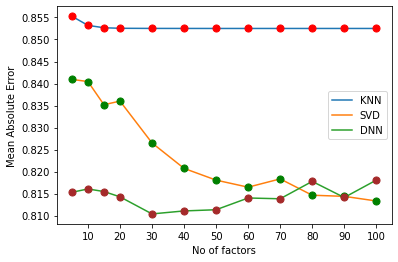

mae
mae_svd [0.8409360751523484, 0.8404434386539776, 0.8351787090096253, 0.8360092061763327, 0.8265017817807114, 0.8207226588199115, 0.8180569153953086, 0.8164519420864585, 0.8183354864174198, 0.8146252420359832, 0.8143705794905562, 0.8133188125327965]
mae_knn [0.8552804076599626, 0.8532044799597551, 0.8526680674367112, 0.8525444677652285, 0.8525168677863482, 0.8525103655838698, 0.8525056536269909, 0.8525058039661068, 0.8525058039661068, 0.8525058039661068, 0.8525058039661068, 0.8525058039661068]
mae_ncf [0.8152966550004134, 0.8160485886806315, 0.8154639024420699, 0.814261085510059, 0.8103801561430045, 0.8110584481079691, 0.8113294171819213, 0.8139959576182051, 0.8138208331297737, 0.817764837756957, 0.8141106187310561, 0.8180584565959239]


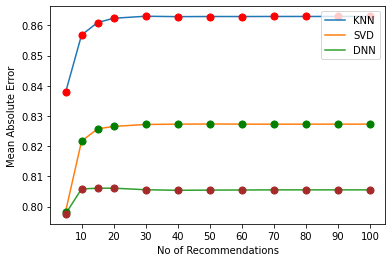

accuracy
accuracy_svd [0.7982939566514845, 0.821651812039717, 0.8257163559360026, 0.8265144758115529, 0.8271750844336813, 0.8272644505061079, 0.8273258451848517, 0.8272766786579582, 0.827262452705167, 0.8272696390703809, 0.82728027780551, 0.82728027780551]
accuracy_knn [0.8377630510531505, 0.8568000849836381, 0.8609211075110679, 0.8623399380332385, 0.8630096957933029, 0.8628772742830935, 0.8629244624824011, 0.862917408917438, 0.8629356834748342, 0.8629352473801546, 0.8629392670461297, 0.8629392670461297]
accuracy_dnn [0.7975449120497259, 0.8058261882451844, 0.8060506819646729, 0.8060734334393747, 0.8055530238087004, 0.8053646285711211, 0.8054322035115374, 0.8054648545889316, 0.8055100887923952, 0.8055100887923952, 0.8055100887923952, 0.8055100887923952]


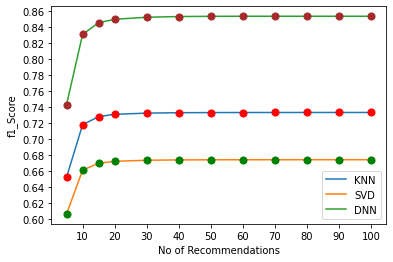

f1_Score
f1_Score_nn [0.743200127324673, 0.8310512598027944, 0.8457261961039794, 0.8499677468946115, 0.8525473765489974, 0.8534123616835563, 0.8537024967211466, 0.8537887785839852, 0.8537940173290786, 0.8537940173290786, 0.8537940173290786, 0.8537940173290786]
f1_Score_knn [0.6522685511744399, 0.7179250318538697, 0.7279674454451701, 0.7309472428784272, 0.7324271588647036, 0.7329487021863602, 0.7331173119043152, 0.7331788211323255, 0.7332114494857678, 0.7332363428001348, 0.733245450110269, 0.733245450110269]
f1_Score_svd [0.6061566695397193, 0.6609576487823602, 0.6696307400269758, 0.6720826623549705, 0.6733730712314157, 0.6738119701998609, 0.6739510662587538, 0.6740056927860989, 0.6740338036036834, 0.6740539553343613, 0.6740585652073923, 0.6740585652073923]
entropy
entropy_svd [1.1429446772477008, 1.5012922256528696, 2.066221673453127, 2.5069468266298975, 3.0698586606469838, 3.451087454524679, 3.7377631636677355, 3.933428358620678, 4.113145917720763, 4.264034707942833, 4.399545678869065

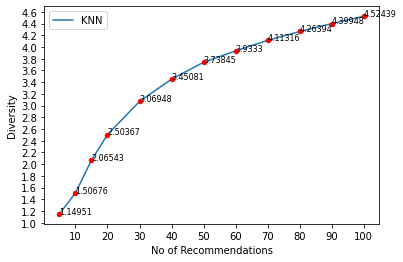

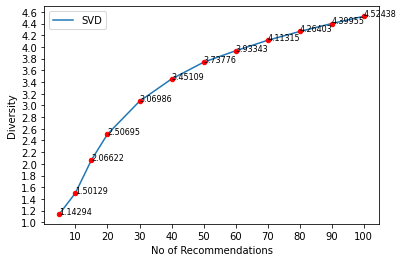

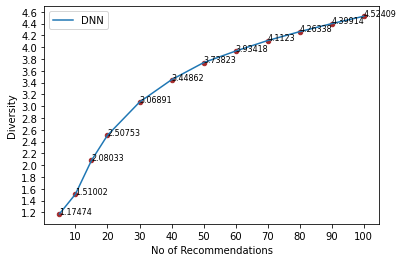

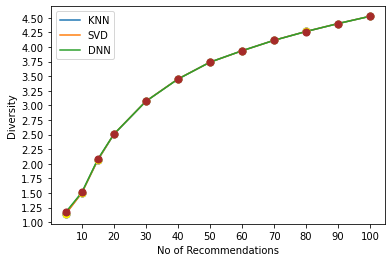

f1_Score
f1_Score_nn [0.743200127324673, 0.8310512598027944, 0.8457261961039794, 0.8499677468946115, 0.8525473765489974, 0.8534123616835563, 0.8537024967211466, 0.8537887785839852, 0.8537940173290786, 0.8537940173290786, 0.8537940173290786, 0.8537940173290786]
f1_Score_knn [0.6522685511744399, 0.7179250318538697, 0.7279674454451701, 0.7309472428784272, 0.7324271588647036, 0.7329487021863602, 0.7331173119043152, 0.7331788211323255, 0.7332114494857678, 0.7332363428001348, 0.733245450110269, 0.733245450110269]
f1_Score_svd [0.6061566695397193, 0.6609576487823602, 0.6696307400269758, 0.6720826623549705, 0.6733730712314157, 0.6738119701998609, 0.6739510662587538, 0.6740056927860989, 0.6740338036036834, 0.6740539553343613, 0.6740585652073923, 0.6740585652073923]


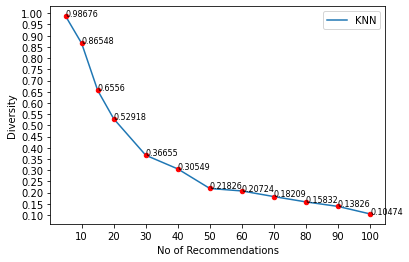

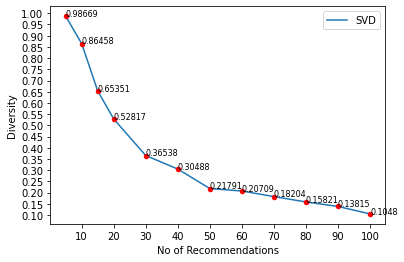

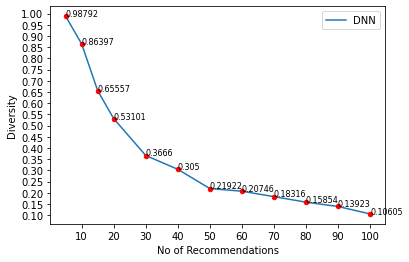

diversity
divesity_knn [0.9867552943045838, 0.8654769188106266, 0.6555989905537736, 0.5291820945250147, 0.3665458583337601, 0.3054927666811905, 0.2182586900780462, 0.20723882619911504, 0.18208509823406338, 0.15831877206645506, 0.13826059109719324, 0.10474192526515114]
diversity_nn [0.9879209888138601, 0.8639657081251949, 0.6555672453936021, 0.5310119410559482, 0.3666037990711254, 0.3049975067570043, 0.21921947734052427, 0.20745675328003477, 0.18316045465931718, 0.15854357999396496, 0.1392250565941625, 0.10605231391886061]
diversity_svd [0.9866947214585253, 0.8645805975609941, 0.6535130648257648, 0.5281655637550711, 0.3653796665845195, 0.30488133895846026, 0.2179055559519525, 0.20708800554753515, 0.18203903062915783, 0.15820752259589788, 0.13814521987021078, 0.10479722012637793]


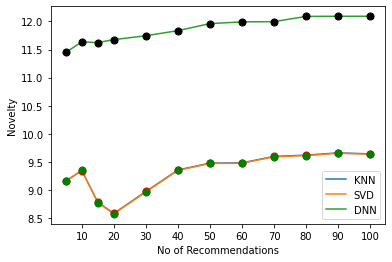

novelty
novelty_knn [9.156185476784444, 9.345812660193934, 8.781798156017757, 8.5831265536009, 8.973821707363967, 9.355876816151165, 9.478771857182902, 9.482778010025546, 9.598110727372086, 9.620155755654732, 9.661148760299051, 9.643120934783122]
novelty_nn [11.447906634790238, 11.6372861776724, 11.623665548041894, 11.676633315109779, 11.74584168893564, 11.836511213334743, 11.961435833968716, 11.992933836583388, 11.996512985845426, 12.090138115598586, 12.092276382871967, 12.092832831283001]
novelty_svd [9.164875998018886, 9.349609002456035, 8.774043678133237, 8.574080335735669, 8.965450546190432, 9.348652269397846, 9.47167752796654, 9.475086592350317, 9.590786527016059, 9.61281408296121, 9.6539520325661, 9.63595387641337]


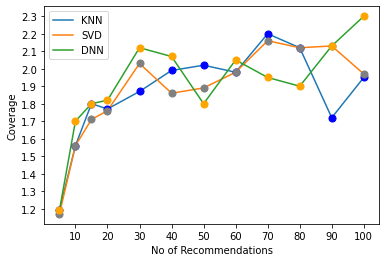

In [63]:
k = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plt.xlabel('No of factors')
plt.ylabel('Mean Absolute Error')
ax=plt.gca()
ax.locator_params('y', nbins=10)

plt.locator_params('x', nbins=20)
plt.plot(k, mae_knn, label = "KNN")
plt.plot(k, mae_svd, label = "SVD")
plt.plot(k, mae_ncf, label = "DNN")
plt.scatter(k,mae_knn,s=50,color='red',zorder=2)
plt.scatter(k,mae_svd,s=50,color='green',zorder=2)
plt.scatter(k,mae_ncf,s=50,color='brown',zorder=2)
plt.legend()
plt.show()

print("mae")
print("mae_svd",mae_svd)
print("mae_knn",mae_knn)
print("mae_ncf",mae_ncf)


plt.xlabel('No of Recommendations')
plt.ylabel('Mean Absolute Error')
ax=plt.gca()
ax.locator_params('y', nbins=10)

plt.locator_params('x', nbins=20)
plt.plot(k, accuracy_knn, label = "KNN")
plt.plot(k, accuracy_svd, label = "SVD")
plt.plot(k, accuracy_nn, label = "DNN")
plt.scatter(k,accuracy_knn,s=50,color='red',zorder=2)
plt.scatter(k,accuracy_svd,s=50,color='green',zorder=2)
plt.scatter(k,accuracy_nn,s=50,color='brown',zorder=2)
plt.legend()
plt.show()

print("accuracy")
print("accuracy_svd",accuracy_svd)
print("accuracy_knn",accuracy_knn)
print("accuracy_dnn",accuracy_nn)

plt.xlabel('No of Recommendations')
plt.ylabel('f1_Score')
ax=plt.gca()
ax.locator_params('y', nbins=15)
plt.locator_params('x', nbins=20)
plt.plot(k, f1_score_knn, label = "KNN")
plt.plot(k, f1_score_svd, label = "SVD")
plt.plot(k, f1_score_nn, label = "DNN")


plt.scatter(k,f1_score_knn,s=50,color='red',zorder=2)
plt.scatter(k,f1_score_svd,s=50,color='green',zorder=2)
plt.scatter(k,f1_score_nn,s=50,color='brown',zorder=2)

plt.legend()
plt.show()

print("f1_Score")
print("f1_Score_nn", f1_score_nn)
print("f1_Score_knn", f1_score_knn)
print("f1_Score_svd", f1_score_svd)

print("entropy")
print("entropy_svd",entropy_svd)
print("entropy_knn",entropy_knn)
print("entropy_dnn",entropy_nn)


plt.xlabel('No of Recommendations')
plt.ylabel('Diversity')
ax=plt.gca()
ax.locator_params('y', nbins=25)
plt.locator_params('x', nbins=20)
for i, txt in enumerate(entropy_knn):
    ax.annotate(round(txt, 5), (k[i],entropy_knn[i]),  fontsize=8)
plt.plot(k, entropy_knn, label = "KNN")
plt.scatter(k,entropy_knn,s=20,color='red',zorder=2)
plt.legend()
plt.show()


plt.xlabel('No of Recommendations')
plt.ylabel('Diversity')
ax=plt.gca()
ax.locator_params('y', nbins=25)
plt.locator_params('x', nbins=20)
for i, txt in enumerate(entropy_svd):
    ax.annotate(round(txt, 5), (k[i],entropy_svd[i]),  fontsize=8)
plt.plot(k, entropy_svd, label = "SVD")


plt.scatter(k,entropy_svd,s=20,color='red',zorder=2)

plt.legend()
plt.show()


plt.xlabel('No of Recommendations')
plt.ylabel('Diversity')
ax=plt.gca()
ax.locator_params('y', nbins=25)
plt.locator_params('x', nbins=20)
for i, txt in enumerate(entropy_nn):
    ax.annotate(round(txt, 5), (k[i],entropy_nn[i]),  fontsize=8)
plt.plot(k, entropy_nn, label = "DNN")
plt.scatter(k,entropy_nn,s=20,color='brown',zorder=1)
plt.legend()
plt.show()


plt.xlabel('No of Recommendations')
plt.ylabel('Diversity')
ax=plt.gca()
ax.locator_params('y', nbins=15)
plt.locator_params('x', nbins=20)
plt.plot(k, entropy_knn, label = "KNN")
plt.plot(k, entropy_svd, label = "SVD")
plt.plot(k, entropy_nn, label = "DNN")


plt.scatter(k,entropy_knn,s=50,color='blue',zorder=2)
plt.scatter(k,entropy_svd,s=50,color='yellow',zorder=2)
plt.scatter(k,entropy_nn,s=50,color='brown',zorder=2)

plt.legend()
plt.show()

print("f1_Score")
print("f1_Score_nn", f1_score_nn)
print("f1_Score_knn", f1_score_knn)
print("f1_Score_svd", f1_score_svd)



plt.xlabel('No of Recommendations')
plt.ylabel('Diversity')
ax=plt.gca()
ax.locator_params('y', nbins=25)
plt.locator_params('x', nbins=20)
for i, txt in enumerate(diversity_knn):
    ax.annotate(round(txt, 5), (k[i],diversity_knn[i]),  fontsize=8)
plt.plot(k, diversity_knn, label = "KNN")
plt.scatter(k,diversity_knn,s=20,color='red',zorder=2)
plt.legend()
plt.show()


plt.xlabel('No of Recommendations')
plt.ylabel('Diversity')
ax=plt.gca()
ax.locator_params('y', nbins=25)
plt.locator_params('x', nbins=20)
for i, txt in enumerate(diversity_svd):
    ax.annotate(round(txt, 5), (k[i],diversity_svd[i]),  fontsize=8)
plt.plot(k, diversity_svd, label = "SVD")


plt.scatter(k,diversity_svd,s=20,color='red',zorder=2)

plt.legend()
plt.show()


plt.xlabel('No of Recommendations')
plt.ylabel('Diversity')
ax=plt.gca()
ax.locator_params('y', nbins=25)
plt.locator_params('x', nbins=20)
for i, txt in enumerate(diversity_nn):
    ax.annotate(round(txt, 5), (k[i],diversity_nn[i]),  fontsize=8)
plt.plot(k, diversity_nn, label = "DNN")
plt.scatter(k,diversity_nn,s=20,color='red',zorder=2)
plt.legend()
plt.show()

print("diversity")
print("divesity_knn", diversity_knn)
print("diversity_nn",diversity_nn)
print("diversity_svd",diversity_svd)

plt.xlabel('No of Recommendations')
plt.ylabel('Novelty')
ax=plt.gca()
ax.locator_params('y', nbins=15)
plt.locator_params('x', nbins=20)
plt.plot(k, novelty_knn, label = "KNN")
plt.plot(k, novelty_svd, label = "SVD")
plt.plot(k, novelty_nn, label = "DNN")

plt.scatter(k,novelty_knn,s=50,color='red',zorder=2)
plt.scatter(k,novelty_svd,s=50,color='green',zorder=2)
plt.scatter(k,novelty_nn,s=50,color='black',zorder=2)

plt.legend()
plt.show()

print("novelty")
print("novelty_knn", novelty_knn)
print("novelty_nn",novelty_nn)
print("novelty_svd",novelty_svd)

plt.xlabel('No of Recommendations')
plt.ylabel('Coverage')
ax=plt.gca()
ax.locator_params('y', nbins=15)
plt.locator_params('x', nbins=20)
plt.plot(k, coverage_knn, label = "KNN")
plt.plot(k, coverage_svd, label = "SVD")
plt.plot(k, coverage_nn, label = "DNN")

plt.scatter(k,coverage_knn,s=50,color='blue',zorder=2)
plt.scatter(k,coverage_svd,s=50,color='grey',zorder=2)
plt.scatter(k,coverage_nn,s=50,color='orange',zorder=2)

plt.legend()
plt.show()

